In [1]:
#Import relevant python packages
import os
import pandas as pd
import time
import numpy as np
import random
import requests
import tracemalloc
from sklearn.decomposition import PCA
from tqdm import tqdm
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations
from collections import defaultdict
import gensim
import networkx as nx
from community import community_louvain

## **Goodreads Dataset Procurement and Processing**
### Scraping and collecting data

In [2]:
class GoodreadsDataset:
    
    def __init__(self, save_path: Path, num_pages: int):
        self.save_path = save_path
        self.num_pages = num_pages
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
        }
        self.home_url = "https://www.goodreads.com"
        self.base_url = "https://www.goodreads.com/list/show/1.Best_Books_Ever?page="
        self.books_data = []

    @staticmethod
    def retrieve_genres(headers: dict, book_url: str):
        # Make a request to fetch the book page for the provided book url.
        response = requests.get(url=book_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        # Identify genres using the HTML structure belonging to the genre category.
        genres = soup.select('a[href*="/genres/"]')
        return genres
    
    @staticmethod
    def to_csv(books_data: list, file_name: str):
        df = pd.DataFrame(books_data)
        df.to_csv(file_name, index=False)
        
    @staticmethod
    def scrape_bookpage(books_data: list, headers: dict, base_url: str, home_url: str, page: int):
        # Formulate bookpage url. 
        url = base_url + str(page)
        # Make a request to fetch the page content.
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        # Find all books within the page content. 
        books = soup.find_all('tr', itemtype="http://schema.org/Book")
        for book in books:
            try:
                title = book.find('a', class_="bookTitle")
                author = book.find('a', class_="authorName")
                rating = book.find('span', class_="minirating")
                book_url = home_url + title['href']
                genres = GoodreadsDataset.retrieve_genres(headers, book_url)
                # Remove leading and trailing whitespaces.
                title = title.text.strip()
                author = author.text.strip()
                rating = rating.text.strip()[:4]
                genres = [genre.text.strip() for genre in genres]
                # Construct dictionary to store fetched book data. 
                book_data = {
                    'Title': title,
                    'Author': author,
                    'Rating': rating,
                    'Genres': genres
                }
                books_data.append(book_data)
                # Implement a request delay, to ensure continous access to scraping API.
                time.sleep(2)
            except (AttributeError, ValueError):
                continue
        
        return books_data
    
    def main(self):

        filename = "final_goodreads_dataset.csv"
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

        filepath = os.path.join(self.save_path, filename)
        
        if not os.path.exists(filepath):
            for page in range(self.num_pages):
                print(f"Fetching books metadata from page {page}")
                books_data = self.scrape_bookpage(self.books_data, self.headers, self.base_url, self.home_url, page)
                self.books_data.extend(books_data)
                self.to_csv(self.books_data, filepath)
        else:
            print(f"Dataset CSV file already exists.")

In [3]:
filepath = os.path.join("./data", "final_goodreads_dataset.csv")

if not os.path.exists(filepath):
    dataset = GoodreadsDataset("./data", 100)
    dataset.main()

dataset_df = pd.read_csv(filepath)


In [4]:
dataset_df.head(10)

,Title,Author,Rating,Genres
0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.34,"['Young Adult', 'Fiction', 'Fantasy', 'Science..."
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.50,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',..."
2,Pride and Prejudice,Jane Austen,4.29,"['Fiction', 'Historical Fiction', 'Historical'..."
3,To Kill a Mockingbird,Harper Lee,4.26,"['Fiction', 'Historical Fiction', 'School', 'L..."
4,The Book Thief,Markus Zusak,4.39,"['Historical Fiction', 'Fiction', 'Young Adult..."
5,"Twilight (The Twilight Saga, #1)",Stephenie Meyer,3.66,"['Fantasy', 'Young Adult', 'Romance', 'Fiction..."
6,Animal Farm,George Orwell,3.99,"['Fiction', 'Dystopia', 'Fantasy', 'School', '..."
7,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,4.61,"['Fantasy', 'Fiction', 'Classics', 'Adventure'..."
8,The Chronicles of Narnia (The Chronicles of Na...,C.S. Lewis,4.28,"['Fantasy', 'Classics', 'Fiction', 'Young Adul..."
9,The Fault in Our Stars,John Green,4.13,"['Young Adult', 'Fiction', 'Contemporary', 'Re..."


In [5]:
# number of rows with unique "Title"
dataset_df['Title'].nunique()

9732

### Cleaning and preprocessing of data

In [6]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from tqdm.auto import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

class DataPreprocessor:
    def __init__(self, df):
        self.df = df.copy() 
        self.train_data = None
        self.test_data = None
        self.total_steps = 5 
        self.current_step = 0
    
    def _update_progress(self, description):
        """Update the overall progress and display current step"""
        self.current_step += 1
        print(f"\nStep {self.current_step}/{self.total_steps}: {description}")
    
    def clean_data(self):
        print("Starting data preprocessing pipeline...")
        self._update_progress("Checking initial data")
        print(f"Initial shape: {self.df.shape}")
        
        # Remove rows with empty genres
        self._update_progress("Removing empty genres")
        self.df = self.df.dropna(subset=['Genres'])
        print(f"Shape after removing empty genres: {self.df.shape}")
        
        # Clean and convert ratings
        self._update_progress("Cleaning ratings")
        self._clean_ratings()
        print(f"Shape after cleaning ratings: {self.df.shape}")
        
        # Filter non-English titles
        self._update_progress("Filtering non-English titles")
        self._filter_english_titles()
        print(f"Shape after filtering non-English titles: {self.df.shape}")
        
        # Convert genres and final cleanup
        self._update_progress("Processing genres and final cleanup")
        # Convert genres from string to list if they're strings
        if self.df['Genres'].dtype == 'object':
            tqdm.pandas(desc="Converting genres to lists")
            self.df['Genres'] = self.df['Genres'].progress_apply(self._convert_genres_to_list)
        
        # Remove books with empty genre lists
        self.df = self.df[self.df['Genres'].map(len) > 0]
        print(f"Final shape: {self.df.shape}")
        
        print("\nData preprocessing completed!")
        return self.df
    
    def _filter_english_titles(self):
        def is_english(text):
            try:
                return detect(str(text)) == 'en'
            except LangDetectException:
                return False
        
        # Create a progress bar for language detection
        tqdm.pandas(desc="Detecting languages")
        english_mask = self.df['Title'].progress_apply(is_english)
        
        # Store the number of non-English titles for reporting
        non_english_count = (~english_mask).sum()
        
        # Apply the filter
        self.df = self.df[english_mask]
        print(f"Removed {non_english_count} non-English titles")
    
    def _clean_ratings(self):
        def convert_rating(rating):
            try:
                if isinstance(rating, str):
                    rating = ''.join(c for c in rating if c.isdigit() or c == '.')
                return float(rating)
            except:
                return None
        
        # Convert ratings with progress bar
        tqdm.pandas(desc="Converting ratings")
        self.df['Rating'] = self.df['Rating'].progress_apply(convert_rating)
        
        # Remove rows with invalid ratings
        self.df = self.df.dropna(subset=['Rating'])
        
        # Ensure ratings are within valid range (0-5)
        self.df = self.df[self.df['Rating'].between(0, 5)]
    
    def _convert_genres_to_list(self, genres_str):
        if isinstance(genres_str, list):
            return genres_str
        try:
            genres_str = genres_str.strip('[]')
            genres = [g.strip().strip("'").strip('"') for g in genres_str.split(',')]
            return [g for g in genres if g]  # Remove empty strings
        except:
            return []
    
    def create_train_test_split(self, test_size=0.2, random_state=42):
        print("\nCreating train-test split...")
        self.train_data, self.test_data = train_test_split(
            self.df,
            test_size=test_size,
            random_state=random_state
        )
        
        print(f"Training set size: {len(self.train_data)}")
        print(f"Test set size: {len(self.test_data)}")
        
        return self.train_data, self.test_data
    
    def get_genre_statistics(self):
        print("\nCalculating genre statistics...")
        all_genres = []
        for genres in tqdm(self.df['Genres'], desc="Analyzing genres"):
            all_genres.extend(genres)
        
        genre_counts = pd.Series(all_genres).value_counts()
        
        print("\nGenre Statistics:")
        print(f"Total unique genres: {len(genre_counts)}")
        print("\nTop 10 most common genres:")
        print(genre_counts.head(10))
        
        return genre_counts

/Users/albertmoller/anaconda3/envs/datascience/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Apply preprocessing
preprocessor = DataPreprocessor(dataset_df)
cleaned_df = preprocessor.clean_data()

# Create train-test split
train_data, test_data = preprocessor.create_train_test_split()

# Display data info
print("\nDataset info after cleaning:")
print(cleaned_df.info())

# Display some statistics
print("\nRating statistics:")
print(cleaned_df['Rating'].describe())

# Get genre statistics
genre_stats = preprocessor.get_genre_statistics()

# Create train-test split
train_data, test_data = preprocessor.create_train_test_split()

# Display sample of cleaned data
print("\nSample of cleaned data:")
print(cleaned_df.head(5))

Starting data preprocessing pipeline...

Step 1/5: Checking initial data
Initial shape: (9732, 4)

Step 2/5: Removing empty genres
Shape after removing empty genres: (9732, 4)

Step 3/5: Cleaning ratings


Converting ratings: 100%|██████████| 9732/9732 [00:00<00:00, 838533.38it/s]


Shape after cleaning ratings: (9580, 4)

Step 4/5: Filtering non-English titles


Detecting languages: 100%|██████████| 9580/9580 [00:18<00:00, 508.68it/s]


Removed 2039 non-English titles
Shape after filtering non-English titles: (7541, 4)

Step 5/5: Processing genres and final cleanup


Converting genres to lists: 100%|██████████| 7541/7541 [00:00<00:00, 713575.78it/s]


Final shape: (7411, 4)

Data preprocessing completed!

Creating train-test split...
Training set size: 5928
Test set size: 1483

Dataset info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 7411 entries, 1 to 9729
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Title   7411 non-null   object 
 1   Author  7411 non-null   object 
 2   Rating  7411 non-null   float64
 3   Genres  7411 non-null   object 
dtypes: float64(1), object(3)
memory usage: 289.5+ KB
None

Rating statistics:
count    7411.000000
mean        4.064510
std         0.268418
min         0.000000
25%         3.895000
50%         4.080000
75%         4.250000
max         4.960000
Name: Rating, dtype: float64

Calculating genre statistics...


Analyzing genres: 100%|██████████| 7411/7411 [00:00<00:00, 6259361.04it/s]


Genre Statistics:
Total unique genres: 533

Top 10 most common genres:
Fiction               5488
Fantasy               2901
Romance               2068
Young Adult           2057
Audiobook             1967
Classics              1429
Mystery               1409
Contemporary          1297
Historical Fiction    1157
Nonfiction            1050
Name: count, dtype: int64

Creating train-test split...
Training set size: 5928
Test set size: 1483

Sample of cleaned data:
                                               Title           Author  Rating  \
1  Harry Potter and the Order of the Phoenix (Har...     J.K. Rowling    4.50   
3                              To Kill a Mockingbird       Harper Lee    4.26   
4                                     The Book Thief     Markus Zusak    4.39   
5                   Twilight (The Twilight Saga, #1)  Stephenie Meyer    3.66   
7  J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...   J.R.R. Tolkien    4.61   

                                              

## **Frequent itemset algorithms**

### Apriori Algorithm

In [8]:
class Apriori:
    def __init__(self, df: pd.DataFrame, min_support: float):
        self.df = df
        self.min_support = min_support
        self.frequent_itemsets = []
        self.genres_df = self.df['Genres']
        self.df = self.one_hot_encode(self.genres_df)

    @staticmethod
    def one_hot_encode(genres_df: pd.DataFrame):
        one_hot_encoded = genres_df.apply(lambda x: pd.Series(1, index=x)).fillna(0)
        return one_hot_encoded

    @staticmethod
    def retrieve_singletons(df: pd.DataFrame):
        return df.sum(axis=0).to_dict()

    @staticmethod
    def set_of_candidates(itemsets: list[tuple], k: int):
        candidates = set()
        for i in range(len(itemsets)):
            for j in range(i + 1, len(itemsets)):
                ith_itemset = itemsets[i]
                jth_itemset = itemsets[j]
                candidate = tuple(sorted(set(ith_itemset).union(set(jth_itemset))))
                if len(candidate) == k:
                    candidates.add(candidate)
        return list(candidates)

    @staticmethod
    def compute_support(df: pd.DataFrame, itemset: tuple):
        count = df[list(itemset)].all(axis=1).sum() if all(genre in df.columns for genre in itemset) else 0
        support = count / len(df)
        return support
    
    def run_apriori(self, min_confidence: float):

        freq_itemsets = {}
        frequent_1_itemsets = []
    
        # Generate 1-itemsets
        singletons = self.retrieve_singletons(self.df)
        k = 1

        for genre, count in singletons.items():
            support = count / len(self.df)
            if support >= self.min_support:
                self.frequent_itemsets.append({'support': support, 'itemsets': (genre,)})
                frequent_1_itemsets.append((genre,))
        
        freq_itemsets[k] = frequent_1_itemsets
            
        # Generate k-itemsets
        k = 2
        while True:
            candidates = self.set_of_candidates(freq_itemsets[k - 1], k)
            frequent_k_itemsets = []
            frequent_itemsets = []
            for candidate in candidates:
                support = self.compute_support(self.df, candidate)
                if support >= self.min_support:
                    frequent_itemsets.append({'support': support, 'itemsets': (candidate)})
                    frequent_k_itemsets.append(candidate)
            if not frequent_itemsets:
                break
            else:
                freq_itemsets[k] = frequent_k_itemsets
                k += 1
                self.frequent_itemsets.extend(frequent_itemsets)

            

        rules = association_rules(df=pd.DataFrame(self.frequent_itemsets), min_threshold=min_confidence)

        return pd.DataFrame(self.frequent_itemsets), pd.DataFrame(rules)

#### Testing Apriori implementation

In [9]:
# Initialize the A-Priori class.
apriori_custom = Apriori(train_data, min_support=0.05)

# Perform the A-Priori algorithm to generate frequent itemsets and assocation rules. 
frequent_itemsets_apriori, apriori_rules = apriori_custom.run_apriori(min_confidence=0.7)

# Perform the A-Priori algorithm using another python package.
frequent_itemsets = apriori(apriori_custom.df, min_support=0.05, use_colnames=True)

/Users/albertmoller/anaconda3/envs/datascience/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [10]:
print("\nSample of frequent itemsets")
frequent_itemsets_apriori.head(5)



Sample of frequent itemsets


,support,itemsets
0,0.738698,"(Fiction,)"
1,0.058873,"(Humor,)"
2,0.387146,"(Fantasy,)"
3,0.104757,"(Science Fiction,)"
4,0.266700,"(Audiobook,)"


In [11]:
print("\nSample of frequent itemsets obtained using mlxtend")
frequent_itemsets.head(5)


Sample of frequent itemsets obtained using mlxtend


,support,itemsets
0,0.738698,(Fiction)
1,0.058873,(Humor)
2,0.387146,(Fantasy)
3,0.104757,(Science Fiction)
4,0.266700,(Audiobook)


In [12]:
print("\nSample of association rules")
apriori_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5)


Sample of association rules


,antecedents,consequents,support,confidence,lift
0,(Science Fiction Fantasy),(Fiction),0.053475,0.963526,1.304357
1,(Thriller),(Mystery),0.111505,0.834596,4.389960
2,(Novels),(Fiction),0.103745,0.913819,1.237067
3,(Childrens),(Young Adult),0.057186,0.755011,2.725765
4,(Historical),(Historical Fiction),0.087888,0.862583,5.480590


### PCY Algorithm

In [13]:
class PCY:
    def __init__(self, df, min_support, hash_size=10):
        self.df = df
        self.min_support = min_support
        self.hash_size = hash_size
        self.freq_itemsets = []
        self.genres_df = self.df['Genres']
        self.df = self.one_hot_encode(self.genres_df)  # One-hot encode genres for transaction format
        self.transactions = self.df_to_transactions() 
        self.num_transactions = len(self.transactions)

    @staticmethod
    def one_hot_encode(genres_df):
        one_hot_encoded = genres_df.apply(lambda x: pd.Series(1, index=x)).fillna(0)
        return one_hot_encoded

    def df_to_transactions(self):
        # Convert one-hot encoded df to list of transactions
        transactions = []
        for _, row in self.df.iterrows():
            transaction = row.index[row == 1].tolist() 
            transactions.append(transaction)
        return transactions

    def filter_freq_items(self, item_count):
        # Filters based on minimum support threshold
        freq_items = set()
        for item, count in item_count.items():
            if count / self.num_transactions >= self.min_support:
                freq_items.add(item)

        return freq_items
    
    def filter_freq_buckets_to_bitmap(self, hash_table):
        # Converts frequent buckets into a bitmap
        bitmap = np.zeros(self.hash_size, dtype=bool)
        for i, count in enumerate(hash_table):
            if count / self.num_transactions >= self.min_support:
                bitmap[i] = True
        return bitmap
    
    def pass_one(self):
        # Count single items and hash item pairs into buckets
        item_count = defaultdict(int)
        hash_table = np.zeros(self.hash_size, dtype=int)

        for transaction in self.transactions:
            for item in transaction:
                item_count[item] += 1
            for item_pair in combinations(transaction, 2):
                hash_value = hash(frozenset(item_pair)) % self.hash_size  
                hash_table[hash_value] += 1

        return item_count, hash_table

    def pass_two(self, freq_items, bitmap):
        # Count pairs that are both frequent items and hashed to frequent buckets using the bitmap
        pair_count = defaultdict(int)

        for transaction in self.transactions:
            for item_pair in combinations(transaction, 2):
                if item_pair[0] in freq_items and item_pair[1] in freq_items:
                    hash_value = hash(frozenset(item_pair)) % self.hash_size
                    if bitmap[hash_value]:  
                        pair_count[item_pair] += 1

        freq_pairs = {}
        for pair, count in pair_count.items():
            support = count / self.num_transactions
            if support >= self.min_support:
                freq_pairs[pair] = count

        return freq_pairs

    def run_pcy(self, min_confidence: float):
        item_count, hash_table = self.pass_one()

        freq_items = self.filter_freq_items(item_count)

        # Only keep items that meet the minimum support threshold
        filtered_item_count = {item: count for item, count in item_count.items() if item in freq_items}

        bitmap = self.filter_freq_buckets_to_bitmap(hash_table)

        freq_pairs = self.pass_two(freq_items, bitmap)

        for item, count in filtered_item_count.items():
            support = count / self.num_transactions
            if support >= self.min_support:  
                itemset = {'support': support, 'itemsets': (item,)}
                self.freq_itemsets.append(itemset)

        for pair, count in freq_pairs.items():
            support = count / self.num_transactions
            itemset = {'support': support, 'itemsets': set(pair)}
            self.freq_itemsets.append(itemset)

        rules = association_rules(df=pd.DataFrame(self.freq_itemsets), min_threshold=min_confidence)

        return pd.DataFrame(self.freq_itemsets), pd.DataFrame(rules)


#### Testing PCY implementation

In [14]:
# Initialize the Apriori class.
pcy_custom = PCY(train_data, min_support=0.05)

# Perform the PCY algorithm to generate frequent itemsets and assocation rules. 
frequent_itemsets_pcy, pcy_rules = pcy_custom.run_pcy(min_confidence=0.7)

In [15]:
print("\nSample of frequent itemsets")
frequent_itemsets_pcy.head(5)


Sample of frequent itemsets


,support,itemsets
0,0.738698,"(Fiction,)"
1,0.058873,"(Humor,)"
2,0.387146,"(Fantasy,)"
3,0.104757,"(Science Fiction,)"
4,0.266700,"(Audiobook,)"


In [16]:
print("\nSample of association rules")
pcy_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5)


Sample of association rules


,antecedents,consequents,support,confidence,lift
0,(Fantasy),(Fiction),0.321019,0.829194,1.122508
1,(Science Fiction),(Fiction),0.098516,0.940419,1.273076
2,(Audiobook),(Fiction),0.209177,0.784314,1.061752
3,(Adult),(Fiction),0.070682,0.735088,0.995113
4,(Science Fiction),(Fantasy),0.079960,0.763285,1.971570


#### Quantifying algorithmic performance of A-priori and PCY

In [17]:
class FrequentItemsPerformance:
    
    def __init__(self, apriori: Apriori, pcy: PCY):
        
        self.apriori = apriori
        self.pcy = pcy

    @staticmethod
    def time(func: callable, *args):
        start = time.time()
        result = func(*args)
        end = time.time()
        time_taken = end - start
        return result, time_taken
    
    @staticmethod
    def patterns(result: tuple):
        frequent_itemsets, rules = result
        return len(frequent_itemsets), len(rules)
    
    @staticmethod
    def memory(func: callable, *args):
        tracemalloc.start()
        result = func(*args)
        size, peak_size = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        return result, peak_size
    
    def compare_algorithms(self, df: pd.DataFrame, min_confidence: float):
        # Intiailize an empty list to store performance results.
        apriori_results = []
        pcy_results = []

        for min_support in tqdm([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]):

            # Compute performance metrics using A-priori
            apriori_instance = self.apriori(df, min_support)
            apriori_result, apriori_time = self.time(apriori_instance.run_apriori, min_confidence)
            apriori_instance = self.apriori(df, min_support)
            _, apriori_memory = self.memory(apriori_instance.run_apriori, min_confidence)
            apriori_num_freqitems, apriori_num_rules = self.patterns(apriori_result)

            # Compute performance metrics using PCY
            pcy_instance = self.pcy(df, min_support)
            pcy_result, pcy_time = self.time(pcy_instance.run_pcy, min_confidence)
            pcy_instance = self.pcy(df, min_support)
            _, pcy_memory = self.memory(pcy_instance.run_pcy, min_confidence)
            pcy_num_freqitems, pcy_num_rules = self.patterns(pcy_result)
        
            # Save results
            apriori_results.append({
                "Support": min_support,
                "Time (seconds)": apriori_time,
                "Memory (KB)": apriori_memory / 1024,
                "Frequent Items Found": apriori_num_freqitems,
                "Association rules Found": apriori_num_rules
            })
            pcy_results.append({
                "Support": min_support,
                "Time (seconds)": pcy_time,
                "Memory (KB)": pcy_memory / 1024,
                "Frequent Items Found": pcy_num_freqitems,
                "Association rules Found": pcy_num_rules
            })

        return pd.DataFrame(apriori_results), pd.DataFrame(pcy_results)

In [18]:
apriori_custom = Apriori
pcy_custom = PCY

performance = FrequentItemsPerformance(apriori_custom, pcy_custom)
apriori_results, pcy_results = performance.compare_algorithms(df=train_data, min_confidence=0.7)

100%|██████████| 10/10 [00:38<00:00,  3.88s/it]


In [19]:
# Display performance results
apriori_results.head(10)


,Support,Time (seconds),Memory (KB),Frequent Items Found,Association rules Found
0,0.01,2.661436,3073.429688,1215,2081
1,0.05,0.189295,3073.429688,139,155
2,0.10,0.043104,3073.429688,36,17
3,0.15,0.014401,3073.429688,18,7
4,0.20,0.007031,3073.429688,8,3
5,0.25,0.006249,3073.429688,6,1
6,0.30,0.004006,3073.429688,3,1
7,0.40,0.003812,3073.429688,1,0
8,0.50,0.003277,3073.429688,1,0
9,0.60,0.004129,3073.429688,1,0


In [20]:
# Display performance results
pcy_results.head(10)

,Support,Time (seconds),Memory (KB),Frequent Items Found,Association rules Found
0,0.01,0.057025,542.049805,448,148
1,0.05,0.049673,115.882812,93,43
2,0.10,0.045759,59.640625,33,12
3,0.15,0.040461,49.281250,17,6
4,0.20,0.037925,43.359375,8,3
5,0.25,0.038324,44.710938,6,1
6,0.30,0.036246,39.936523,3,1
7,0.40,0.035614,33.207031,1,0
8,0.50,0.035226,30.143555,1,0
9,0.60,0.035443,30.143555,1,0


## **Clustering**

### K-Means Clustering

In [21]:
from sklearn.metrics import silhouette_score

class KMeansClustering:
    def __init__(self, df, n_clusters=3, random_state=42):
        self.df = df.copy()
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.genre_to_index = {}
        self.all_genres = []
        self.feature_matrix = None
        self.custom_labels = None
        self.sklearn_labels = None
        self.custom_centroids = None
        self.sklearn_centroids = None
        self.X_pca = None

    def prepare_data(self):
        # Get all unique genres
        all_genres = set()
        for genres in self.df['Genres']:
            all_genres.update(genres)
        self.all_genres = sorted(all_genres)
        
        # Create a mapping from genre to index
        self.genre_to_index = {genre: idx for idx, genre in enumerate(self.all_genres)}
        
        # Convert genres to one-hot encoded vectors
        self.df['Genre_Vector'] = self.df['Genres'].apply(self._genres_to_onehot)
        
        # Scale the Rating feature
        scaler = StandardScaler()
        self.df['Scaled_Rating'] = scaler.fit_transform(self.df[['Rating']])
        
        # Combine Genre_Vector and Scaled_Rating into a single feature vector
        feature_vectors = np.stack(self.df['Genre_Vector'].values)
        ratings = self.df['Scaled_Rating'].values.reshape(-1, 1)
        self.feature_matrix = np.hstack((feature_vectors, ratings))

    def _genres_to_onehot(self, genres_list):
        vector = np.zeros(len(self.all_genres))
        for genre in genres_list:
            idx = self.genre_to_index.get(genre)
            if idx is not None:
                vector[idx] = 1
        return vector

    def fit_custom_kmeans(self):
        # Implement K-means clustering
        np.random.seed(self.random_state)
        initial_centroid_indices = np.random.choice(len(self.feature_matrix), self.n_clusters, replace=False)
        self.custom_centroids = self.feature_matrix[initial_centroid_indices]
        
        for iteration in range(300):  # max_iter=300
            # Assign clusters
            distances = self._compute_distances(self.feature_matrix, self.custom_centroids)
            labels = np.argmin(distances, axis=1)
            # Update centroids
            new_centroids = np.zeros_like(self.custom_centroids)
            for k in range(self.n_clusters):
                cluster_points = self.feature_matrix[labels == k]
                if len(cluster_points) > 0:
                    new_centroids[k] = cluster_points.mean(axis=0)
                else:
                    # Reinitialize centroid if cluster is empty
                    new_centroids[k] = self.feature_matrix[np.random.choice(len(self.feature_matrix))]
            # Check for convergence
            if np.allclose(self.custom_centroids, new_centroids, atol=1e-4):
                break
            self.custom_centroids = new_centroids
        self.custom_labels = labels

    def fit_sklearn_kmeans(self):
        kmeans = KMeans(
            n_clusters=self.n_clusters,
            init=self.custom_centroids,
            n_init=1,
            max_iter=300,
            tol=1e-4,
            algorithm='lloyd', 
            random_state=self.random_state
        )
        kmeans.fit(self.feature_matrix)
        self.sklearn_labels = kmeans.labels_
        self.sklearn_centroids = kmeans.cluster_centers_

    def _compute_distances(self, X, centroids):
        return np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    def calculate_davies_bouldin_index(self, labels, centroids):
        n_clusters = len(centroids)
        cluster_k = [self.feature_matrix[labels == k] for k in range(n_clusters)]
        s = [np.mean(np.linalg.norm(cluster - centroids[i], axis=1)) for i, cluster in enumerate(cluster_k)]
        db_index = 0
        for i in range(n_clusters):
            max_ratio = max(
                [(s[i] + s[j]) / np.linalg.norm(centroids[i] - centroids[j]) 
                 for j in range(n_clusters) if j != i]
            )
            db_index += max_ratio
        db_index /= n_clusters
        return db_index

    def visualize_clusters(self, labels, title):
        # Reduce dimensions to 2D using PCA
        pca = PCA(n_components=2)
        self.X_pca = pca.fit_transform(self.feature_matrix)
        
        # Plotting
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(self.X_pca[:, 0], self.X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
        plt.legend(*scatter.legend_elements(), title="Clusters")
        plt.title(title)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.show()

    def run_all(self):
        # Prepare data
        self.prepare_data()
        print("Data preparation complete.")
        
        # Fit custom KMeans
        self.fit_custom_kmeans()
        print("Custom KMeans clustering complete.")
        
        # Fit sklearn KMeans
        self.fit_sklearn_kmeans()
        print("sklearn KMeans clustering complete.")
        
        # Calculate Davies-Bouldin Index for custom KMeans
        db_index_custom = self.calculate_davies_bouldin_index(self.custom_labels, self.custom_centroids)
        print("Davies-Bouldin Index (Custom KMeans):", db_index_custom)
        
        # Calculate Davies-Bouldin Index for sklearn KMeans
        db_index_sklearn = self.calculate_davies_bouldin_index(self.sklearn_labels, self.sklearn_centroids)
        print("Davies-Bouldin Index (sklearn KMeans):", db_index_sklearn)

        # Calculate the Silhoutte score.
        silhouette = silhouette_score(self.feature_matrix, self.custom_labels)
        print("Silhoutte score: ", silhouette)
        
        if self.n_clusters == 12:

            # Visualize clusters for custom KMeans
            self.visualize_clusters(self.custom_labels, "Clusters from Custom KMeans")
            # Visualize clusters for sklearn KMeans
            self.visualize_clusters(self.sklearn_labels, "Clusters from sklearn KMeans")

        return db_index_custom, silhouette
    

Data preparation complete.
Custom KMeans clustering complete.
sklearn KMeans clustering complete.
Davies-Bouldin Index (Custom KMeans): 2.557204918126048
Davies-Bouldin Index (sklearn KMeans): 2.5572049181260477
Silhoutte score:  0.10848911265269878


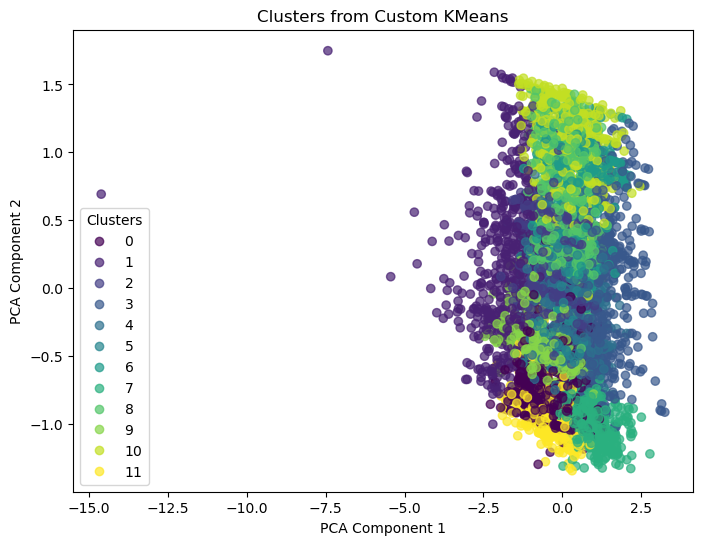

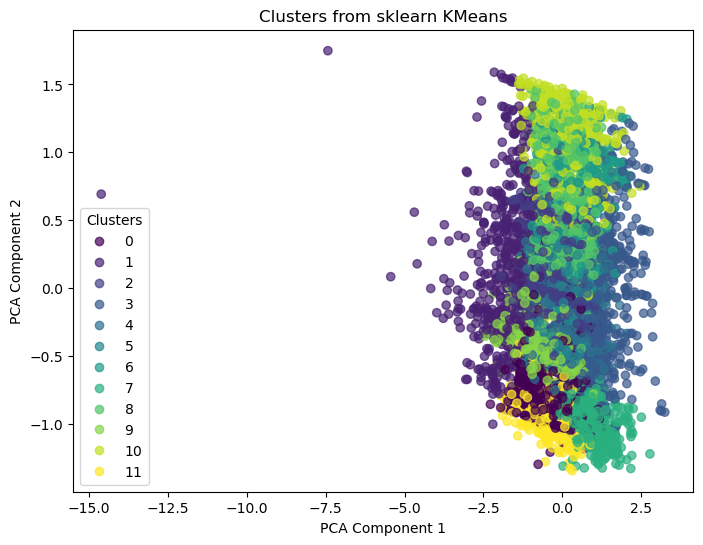

(2.557204918126048, 0.10848911265269878)

In [22]:
# Initialize the clustering class
clustering = KMeansClustering(train_data, n_clusters=12, random_state=42)

# Run all steps
clustering.run_all()


### Quantifying the clustering performance for a various number of clusters

In [23]:
davies_bouldin_scores = []
silhouette_scores = []

for n_cluster in [5, 10, 15, 20, 25, 30, 35, 40, 50, 55, 60]:
    clustering = KMeansClustering(train_data, n_clusters=n_cluster, random_state=42)
    # Run all steps
    davies_bouldin_score, silhouette = clustering.run_all()
    davies_bouldin_scores.append(davies_bouldin_score)
    silhouette_scores.append(silhouette)
   

Data preparation complete.
Custom KMeans clustering complete.
sklearn KMeans clustering complete.
Davies-Bouldin Index (Custom KMeans): 2.7625492352516416
Davies-Bouldin Index (sklearn KMeans): 2.7625492352516385
Silhoutte score:  0.0932025310377621
Data preparation complete.
Custom KMeans clustering complete.
sklearn KMeans clustering complete.
Davies-Bouldin Index (Custom KMeans): 2.5244311575286016
Davies-Bouldin Index (sklearn KMeans): 2.5244311575286016
Silhoutte score:  0.10605943941660737
Data preparation complete.
Custom KMeans clustering complete.
sklearn KMeans clustering complete.
Davies-Bouldin Index (Custom KMeans): 2.521391603371528
Davies-Bouldin Index (sklearn KMeans): 2.521391603371528
Silhoutte score:  0.10846492196271261
Data preparation complete.
Custom KMeans clustering complete.
sklearn KMeans clustering complete.
Davies-Bouldin Index (Custom KMeans): 2.5584052102102626
Davies-Bouldin Index (sklearn KMeans): 2.558405210210263
Silhoutte score:  0.10407452328178042


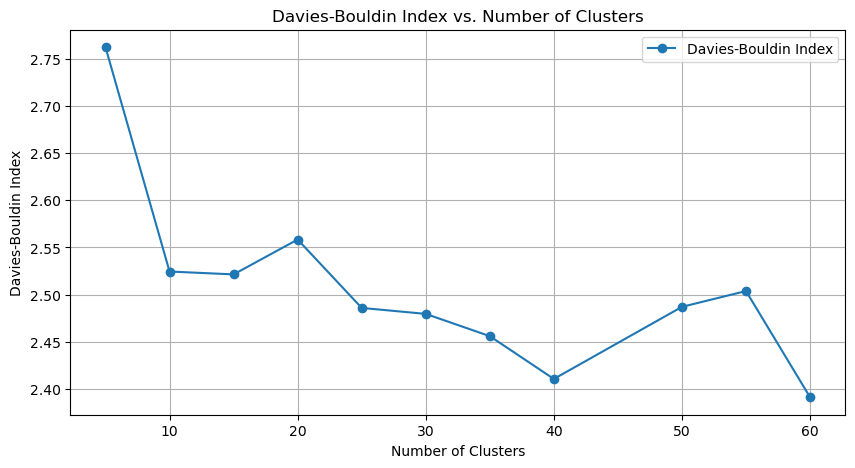

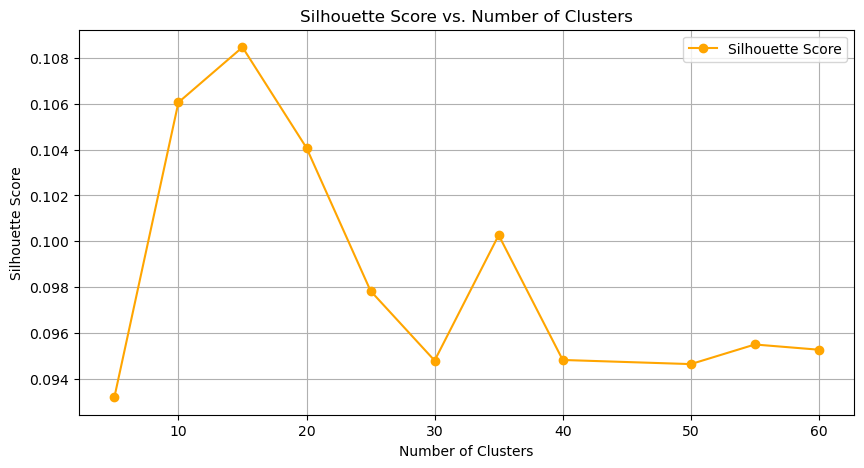

In [24]:
# List of cluster sizes
cluster_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 50, 55, 60]

# Plot Davies-Bouldin Scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_sizes, davies_bouldin_scores, marker='o', label="Davies-Bouldin Index")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.title("Davies-Bouldin Index vs. Number of Clusters")
plt.grid(True)
plt.legend()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_sizes, silhouette_scores, marker='o', label="Silhouette Score", color="orange")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.grid(True)
plt.legend()
plt.show()

## **Word2vec**

In [25]:
class Word2Vec:
    def __init__(self, df):
        self.df = df.copy()
        self.genre_sequences = df['Genres'].tolist()  # Tokenized list of genres
        self.model = None
        self.book_embeddings = {}
        self.G = None
        self.sample_size = 1000
        self.seed = 42

    #Train and save a Word2Vec model based on the genre sequences.
    def train_word2vec(self, vector_size=50, window=3, min_count=1, sg=1, epochs=100):
        
        self.model = gensim.models.Word2Vec(
            sentences=self.genre_sequences,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            sg=sg,
            epochs=epochs,
            seed=self.seed
        )
        self.model.save("genre_word2vec.model")
        print("Word2Vec model trained and saved as 'genre_word2vec.model'.")

    # Precompute and store embeddings for all books in the dataset
    def precompute_book_embeddings(self):
        if self.model is None:
            raise ValueError("Model not trained. Please train model first.")

        self.book_embeddings = {}

        for idx, row in self.df.iterrows():
            genres = row['Genres']
            if isinstance(genres, list):
                # Compute the embedding by averaging genre embeddings
                valid_genres = [genre for genre in genres if genre in self.model.wv]
                if valid_genres:
                    genre_vectors = [self.model.wv[genre] for genre in valid_genres]
                    self.book_embeddings[idx] = np.mean(genre_vectors, axis=0)

        print(f"Precomputed embeddings for {len(self.book_embeddings)} books.")
    

    # Create weighted neighbor graph and visualize it alongside the clustered graph
    def create_and_visualize_graphs(self, k=5, weight_threshold=0.1):
        if not self.book_embeddings:
            raise ValueError("No precomputed embeddings found. Please run precompute_book_embeddings first.")

        # Extract all embeddings
        book_ids = list(self.book_embeddings.keys())
        embeddings_matrix = np.array(list(self.book_embeddings.values()))

        np.random.seed(self.seed)

        # Sample a subset of books
        if self.sample_size < len(book_ids):
            sampled_indices = np.random.choice(len(book_ids), size=self.sample_size, replace=False)
            embeddings_matrix = embeddings_matrix[sampled_indices]
            book_ids = [book_ids[i] for i in sampled_indices]

        # Fit nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(embeddings_matrix)
        distances, indices = nbrs.kneighbors(embeddings_matrix)

        # Create a graph
        self.G = nx.Graph()
        for i, book_id in enumerate(book_ids):
            for neighbor_idx, distance in zip(indices[i], distances[i]):
                neighbor_id = book_ids[neighbor_idx]
                weight = 1 - distance  # Cosine similarity (1 - distance)
                if book_id != neighbor_id and weight >= weight_threshold:
                    self.G.add_edge(book_id, neighbor_id, weight=weight)

        # Initialize the plot with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

        # Plot 1: Weighted Neighbor Graph
        pos = nx.spring_layout(self.G, seed=self.seed)  # Use a fixed seed for consistent layout
        edges, weights = zip(*nx.get_edge_attributes(self.G, 'weight').items())
        nx.draw(
            self.G, pos, ax=axes[0], with_labels=False, node_color='lightblue', edge_color=weights,
            width=[w * 2 for w in weights], node_size=50, edge_cmap=plt.cm.Blues
        )
        axes[0].set_title(f"Sampled Weighted Book Neighbor Graph ({len(self.G.nodes)} books out of {self.sample_size})")

        # Plot 2: Clustered Graph
        # Apply Louvain clustering algorithm
        partition = community_louvain.best_partition(self.G, random_state=self.seed)
        num_clusters = max(partition.values()) + 1
        colors = [partition[node] for node in self.G.nodes]
        nx.draw(
            self.G, pos, ax=axes[1], with_labels=False, node_color=colors, edge_color='gray',
            node_size=50, cmap=plt.cm.rainbow
        )
        axes[1].set_title(f"Book Neighbor Graph with {num_clusters} Clusters ({len(self.G.nodes)} books out of {self.sample_size})")

        # Show the combined plot
        plt.show()

    
    def run_all(self):

        # Train Word2Vec model
        self.train_word2vec()

        # Precompute book embeddings
        self.precompute_book_embeddings()

        # Create and visualize graphs
        self.create_and_visualize_graphs()
        

Word2Vec model trained and saved as 'genre_word2vec.model'.
Precomputed embeddings for 5928 books.


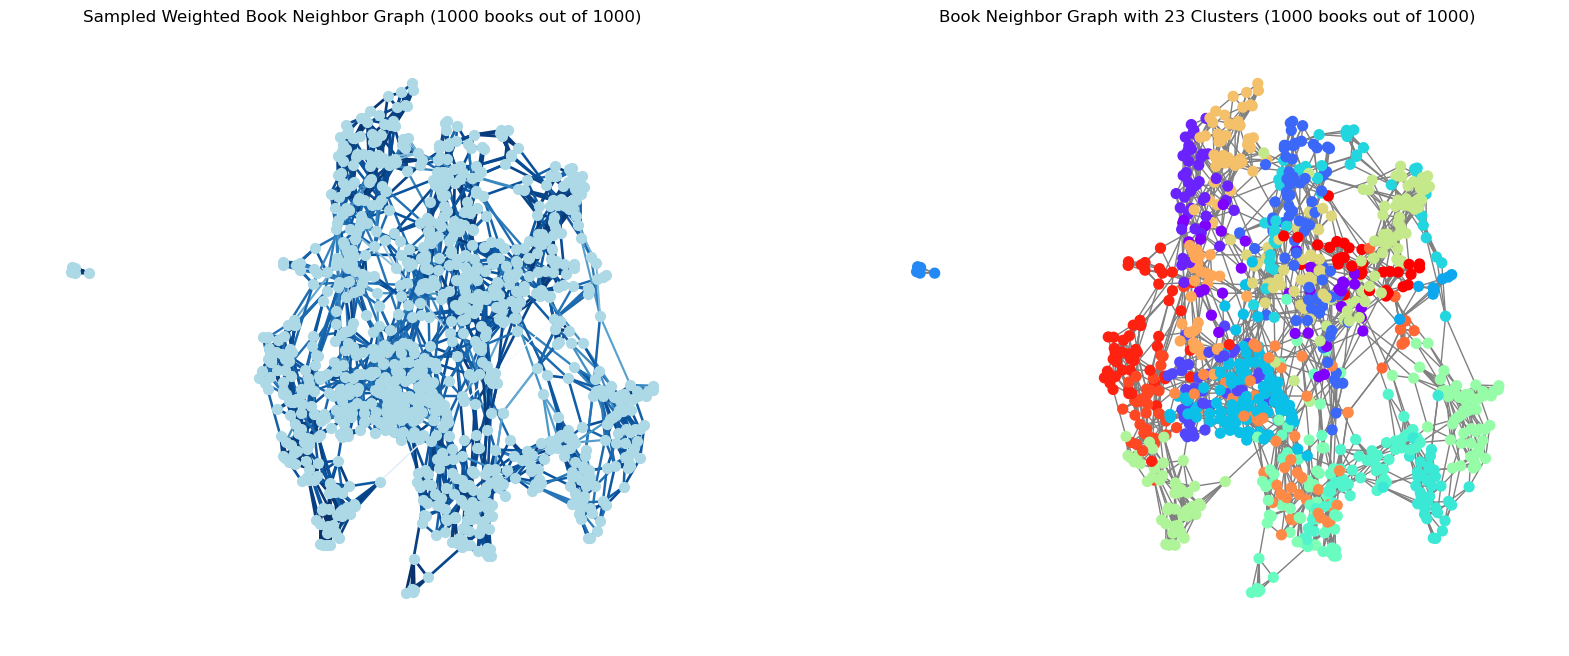

In [26]:
embedded_model = Word2Vec(train_data)
embedded_model.run_all()

## **Recommendation System**

### Using frequent itemsets (Apriori/PCY)

In [27]:
from tqdm import tqdm

def recommend_with_frequent_itemsets(rules: pd.DataFrame, data: pd.DataFrame, algo_type: str):
    """Recommends a single book based on the genres of the input book using either A-Priori or PCY."""

    for row in tqdm(data.itertuples(index=True), total=len(data)): 
        genres = set(row.Genres)
        current_title = row.Title
        recommended_genres = set()
        # Find matching genres using association rule.
        for _, rule in rules.iterrows():
            antecedent = set(rule['antecedents'])
            consequent = set(rule['consequents'])
            if antecedent.issubset(set(genres)):
                recommended_genres.update(consequent)
        # Find books with matching genres.
        data['Intersection Size'] = data['Genres'].apply(lambda x: len(set(x) & set(recommended_genres)))
        recommended_books = data[(data['Title'] != current_title) &  (data['Intersection Size'] > 0)].sort_values(by='Intersection Size', ascending=False)
        if recommended_books.empty:
            data.at[row.Index, f'{algo_type} Recommendations'] = f"No recommendation found for book with title {current_title}"
        else:
            top_recommendation = recommended_books.sort_values(by=['Intersection Size', 'Rating'], ascending=False)['Title'].iloc[0]
            data.at[row.Index, f'{algo_type} Recommendations'] = top_recommendation
        data.drop(columns=['Intersection Size'], inplace=True)

In [28]:
# Ensure titles are unique. 
unique_titles = test_data.drop_duplicates(subset='Title')
# Ensure genres are unique. 
unique_genres = unique_titles.drop_duplicates(subset='Genres')
# Randomly sample 100 for recommendations. 
sampled_data = unique_genres.sample(n=100, random_state=42) 
# Find book recommendations using A-Priori.
recommend_with_frequent_itemsets(apriori_rules, sampled_data, "A-Priori")
# Find book recommendations using PCY.
recommend_with_frequent_itemsets(pcy_rules, sampled_data, "PCY")


100%|██████████| 100/100 [00:00<00:00, 786.92it/s]


In [29]:
sampled_data.head(10)

,Title,Author,Rating,Genres,A-Priori Recommendations,PCY Recommendations
3651,Notes from a Small Island,Bill Bryson,3.91,"[Travel, Nonfiction, Humor, Memoir, British Li...",Dark Voyage Matters of the Mind (The Children ...,Dark Voyage Matters of the Mind (The Children ...
8508,The Violent Bear It Away,Flannery O'Connor,4.08,"[Fiction, Classics, Southern Gothic, Novels, G...",The Thorn Birds,The Thorn Birds
5143,Mr. Popper's Penguins,Richard Atwater,3.97,"[Childrens, Fiction, Classics, Middle Grade, A...",Where the Wild Things Are,Where the Wild Things Are
5157,"And the Band Played On: Politics, People, and ...",Randy Shilts,4.38,"[Nonfiction, History, Politics, Science, LGBT,...",Diplomats & Admirals: From Failed Negotiations...,Diplomats & Admirals: From Failed Negotiations...
116,The Count of Monte Cristo,Alexandre Dumas,4.31,"[Fiction, Historical Fiction, Adventure, Liter...","Lords of the North (The Saxon Stories, #3)","Lords of the North (The Saxon Stories, #3)"
7280,"Endless Knight (The Arcana Chronicles, #2)",Kresley Cole,4.36,"[Fantasy, Young Adult, Paranormal, Romance, Dy...","Lore Olympus: Volume One (Lore Olympus, #1)","Death Note: Black Edition, Vol. 1"
1950,"Wither (The Chemical Garden, #1)",Lauren DeStefano,3.80,"[Young Adult, Dystopia, Romance, Science Ficti...","The Flame of Olympus (Pegasus, #1)","Death Note: Black Edition, Vol. 1"
6855,"Fire with Fire (Burn for Burn, #2)",Jenny Han,4.04,"[Young Adult, Contemporary, Romance, Paranorma...",Dreams of Gods & Monsters (Daughter of Smoke &...,"Death Note: Black Edition, Vol. 1"
3148,A Bright Shining Lie: John Paul Vann and Ameri...,Neil Sheehan,4.24,"[History, Nonfiction, War, Biography, American...","And the Band Played On: Politics, People, and ...","And the Band Played On: Politics, People, and ..."
594,"Bared to You (Crossfire, #1)",Sylvia Day,4.14,"[Romance, Erotica, Contemporary, Contemporary ...",Dark Voyage Matters of the Mind (The Children ...,Dark Voyage Matters of the Mind (The Children ...


### Using clusters (K-means)

In [42]:
def recommend_with_clustering(train_data: pd.DataFrame, test_data: pd.DataFrame, algo_type: str):
    """Recommends a single book based on the genres of the input book using K-Means clustering."""

    def genres_to_onehot(genres_list, all_genres, genre_to_index):
        vector = np.zeros(len(all_genres))
        for genre in genres_list:
            idx = genre_to_index.get(genre)
            if idx is not None:
                vector[idx] = 1
        return vector

    # Get all unique genres from both train and test data.
    all_genres = set()
    for genres in train_data['Genres']:
        all_genres.update(genres)
    for genres in test_data['Genres']:
        all_genres.update(genres)
    all_genres = sorted(all_genres)

    genre_to_index = {genre: idx for idx, genre in enumerate(all_genres)}

    # Create one-hot encoded genre vectors.
    train_data['Genre_Vector'] = train_data['Genres'].apply(lambda x: genres_to_onehot(x, all_genres, genre_to_index))
    test_data['Genre_Vector'] = test_data['Genres'].apply(lambda x: genres_to_onehot(x, all_genres, genre_to_index))

    if algo_type == "K-Means":
        clustering_model = KMeans(
            n_clusters=15,
            n_init=1,
            max_iter=300,
            tol=1e-4,
            algorithm='lloyd', 
            random_state=42
        )

    # Assign clusters to the training data.
    train_data['Cluster'] = clustering_model.fit_predict(np.vstack(train_data['Genre_Vector'].values))

    # Predict clusters for the test data.
    test_data['Cluster'] = clustering_model.fit_predict(np.vstack(test_data['Genre_Vector'].values))

    # Compute recommendation
    test_data[f'{algo_type} Recommendations'] = None
    for idx, row in test_data.iterrows():
        current_cluster = row['Cluster']
        current_title = row['Title']
        
        cluster_books = train_data[train_data['Cluster'] == current_cluster]
        recommendations = cluster_books[cluster_books['Title'] != current_title]
        
        top_recommendation = recommendations.sort_values(by='Rating', ascending=False)['Title'].iloc[0]

        if top_recommendation:
            test_data.at[idx, f'{algo_type} Recommendations'] = top_recommendation
        else:
            test_data.at[idx, f'{algo_type} Recommendations'] = "No recommendations found"

    train_data.drop(columns=['Cluster'], inplace=True)
    test_data.drop(columns=['Cluster'], inplace=True)
    train_data.drop(columns=['Genre_Vector'], inplace=True)
    test_data.drop(columns=['Genre_Vector'], inplace=True)

In [46]:
# Ensure titles are unique. 
unique_titles = test_data.drop_duplicates(subset='Title')
# Ensure genres are unique. 
unique_genres = unique_titles.drop_duplicates(subset='Genres')
# Randomly sample 100 for recommendations. 
sampled_data = unique_genres.sample(n=100, random_state=42) 
# Find book recommendations using A-Priori.
recommend_with_clustering(train_data, sampled_data, "K-Means")

In [47]:
sampled_data.head(10)

,Title,Author,Rating,Genres,K-Means Recommendations
3651,Notes from a Small Island,Bill Bryson,3.91,"[Travel, Nonfiction, Humor, Memoir, British Li...",The Forgotten Lock
8508,The Violent Bear It Away,Flannery O'Connor,4.08,"[Fiction, Classics, Southern Gothic, Novels, G...",Blackout (Arcadia #2)
5143,Mr. Popper's Penguins,Richard Atwater,3.97,"[Childrens, Fiction, Classics, Middle Grade, A...",The Illustrated Vivian Stanshall: A Fairytale ...
5157,"And the Band Played On: Politics, People, and ...",Randy Shilts,4.38,"[Nonfiction, History, Politics, Science, LGBT,...",The Water Walls
116,The Count of Monte Cristo,Alexandre Dumas,4.31,"[Fiction, Historical Fiction, Adventure, Liter...",Clockwork Angel; Clockwork Prince; Clockwork P...
7280,"Endless Knight (The Arcana Chronicles, #2)",Kresley Cole,4.36,"[Fantasy, Young Adult, Paranormal, Romance, Dy...",The Warden and the Wolf King (The Wingfeather ...
1950,"Wither (The Chemical Garden, #1)",Lauren DeStefano,3.80,"[Young Adult, Dystopia, Romance, Science Ficti...",The Warden and the Wolf King (The Wingfeather ...
6855,"Fire with Fire (Burn for Burn, #2)",Jenny Han,4.04,"[Young Adult, Contemporary, Romance, Paranorma...",The Warden and the Wolf King (The Wingfeather ...
3148,A Bright Shining Lie: John Paul Vann and Ameri...,Neil Sheehan,4.24,"[History, Nonfiction, War, Biography, American...",The Forgotten Lock
594,"Bared to You (Crossfire, #1)",Sylvia Day,4.14,"[Romance, Erotica, Contemporary, Contemporary ...",A Man with A White Shadow


### Using Word2Vec

In [48]:
def recommend_with_word2vec(train_data, test_data):
    """ Recommends a single book for each book in the test dataset based on genre similarity using Word2Vec embeddings. """
    
    # Step 1: Create a Word2Vec instance and train the model
    word2vec_model = Word2Vec(train_data)
    word2vec_model.train_word2vec()
    word2vec_model.precompute_book_embeddings()

    # Extract training embeddings and metadata
    embeddings_matrix = np.array(list(word2vec_model.book_embeddings.values()))
    book_indices = list(word2vec_model.book_embeddings.keys())

    # Step 2: Generate recommendations for test books
    recommendations = []
    for _, test_row in test_data.iterrows():
        test_genres = test_row['Genres']

        try:
            # Compute embedding for the test book
            valid_genres = [genre for genre in test_genres if genre in word2vec_model.model.wv]
            if not valid_genres:
                raise ValueError("No valid genres found in the vocabulary.")

            genre_vectors = [word2vec_model.model.wv[genre] for genre in valid_genres]
            test_embedding = np.mean(genre_vectors, axis=0)

            # Compute cosine similarity between test book and all training books
            similarity_scores = cosine_similarity([test_embedding], embeddings_matrix)[0]

            # Find the most similar book
            most_similar_idx = np.argmax(similarity_scores)
            most_similar_id = book_indices[most_similar_idx]

            # Retrieve the title of the most similar book
            top_recommendation = train_data.loc[most_similar_id, 'Title']
            
        except ValueError:
            # Handle cases where no valid genres or neighbors exist
            top_recommendation = "No recommendations found"

        recommendations.append(top_recommendation)

    # Step 3: Add recommendations to the test data
    test_data['Word2Vec Recommendations'] = recommendations


In [49]:
# Ensure titles are unique. 
unique_titles = test_data.drop_duplicates(subset='Title')
# Ensure genres are unique. 
unique_genres = unique_titles.drop_duplicates(subset='Genres')
# Randomly sample 100 for recommendations. 
sampled_data = unique_genres.sample(n=100, random_state=42) 
# Find book recommendations using A-Priori.
recommend_with_word2vec(train_data, sampled_data)


Word2Vec model trained and saved as 'genre_word2vec.model'.
Precomputed embeddings for 5928 books.


In [50]:
sampled_data.head(10)

,Title,Author,Rating,Genres,Word2Vec Recommendations
3651,Notes from a Small Island,Bill Bryson,3.91,"[Travel, Nonfiction, Humor, Memoir, British Li...",The Road to Little Dribbling: Adventures of an...
8508,The Violent Bear It Away,Flannery O'Connor,4.08,"[Fiction, Classics, Southern Gothic, Novels, G...",The Complete Stories
5143,Mr. Popper's Penguins,Richard Atwater,3.97,"[Childrens, Fiction, Classics, Middle Grade, A...","The Black Stallion (The Black Stallion, #1)"
5157,"And the Band Played On: Politics, People, and ...",Randy Shilts,4.38,"[Nonfiction, History, Politics, Science, LGBT,...",The Lost City of the Monkey God
116,The Count of Monte Cristo,Alexandre Dumas,4.31,"[Fiction, Historical Fiction, Adventure, Liter...",The Scarlet Pimpernel
7280,"Endless Knight (The Arcana Chronicles, #2)",Kresley Cole,4.36,"[Fantasy, Young Adult, Paranormal, Romance, Dy...","World After (Penryn & the End of Days, #2)"
1950,"Wither (The Chemical Garden, #1)",Lauren DeStefano,3.80,"[Young Adult, Dystopia, Romance, Science Ficti...","Specials (Uglies, #3)"
6855,"Fire with Fire (Burn for Burn, #2)",Jenny Han,4.04,"[Young Adult, Contemporary, Romance, Paranorma...",Cryer's Cross
3148,A Bright Shining Lie: John Paul Vann and Ameri...,Neil Sheehan,4.24,"[History, Nonfiction, War, Biography, American...",We Were Soldiers Once... and Young: Ia Drang -...
594,"Bared to You (Crossfire, #1)",Sylvia Day,4.14,"[Romance, Erotica, Contemporary, Contemporary ...","Captivated by You (Crossfire, #4)"


## **Evaluation and Metrics**

### Word2Vec

In [51]:
def evaluate_word2vec(train_data, test_data, top_n=10):
    """ Evaluates the Word2Vec model using similarity metrics.
    Calculates metrics between the top_n recommendations vs. the remaining books. """

    # Step 1: Create a Word2Vec instance and train the model
    word2vec_model = Word2Vec(train_data)
    word2vec_model.train_word2vec()
    word2vec_model.precompute_book_embeddings()

    # Extract training embeddings and metadata
    embeddings_matrix = np.array(list(word2vec_model.book_embeddings.values()))

    # Initialize metrics storage
    metrics = []

    # Step 2: Compute similarity metrics for each test book
    for _, test_row in test_data.iterrows():
        test_genres = test_row['Genres']

        # Check valid genres
        valid_genres = [genre for genre in test_genres if genre in word2vec_model.model.wv]
        if not valid_genres:
            print(f"Skipping book '{test_row['Title']}' (no valid genres)")
            metrics.append({
                "Title": test_row['Title'],
                "silhouette_score": None,
                "cohesion": None,
                "separation": None,
                "neighborhood_density": None
            })
            continue

        # Compute embedding for the test book
        genre_vectors = [word2vec_model.model.wv[genre] for genre in valid_genres]
        test_embedding = np.mean(genre_vectors, axis=0)

        # Compute cosine similarity between test book and all training books
        similarity_scores = cosine_similarity([test_embedding], embeddings_matrix)[0]

        # Sort similarities in descending order and get the top_n recommendations
        sorted_indices = np.argsort(similarity_scores)[::-1][:top_n]
        top_k_similarities = similarity_scores[sorted_indices]

        # Calculate metrics
        cohesion = np.mean(top_k_similarities)
        remaining_similarities = similarity_scores[top_n:] if len(similarity_scores) > top_n else np.array([])
        separation = np.mean(remaining_similarities) if remaining_similarities.size > 0 else 0

        silhouette = (separation - cohesion) / max(separation, cohesion) if max(separation, cohesion) != 0 else 0

        top_k_embeddings = embeddings_matrix[sorted_indices]
        density = np.mean(cosine_similarity(top_k_embeddings))

        metrics.append({
            "Title": test_row['Title'],
            "silhouette_score": silhouette,
            "cohesion": cohesion,
            "separation": separation,
            "neighborhood_density": density
        })

    # Step 3: Convert metrics to a DataFrame and return
    metrics_df = pd.DataFrame(metrics)
    return metrics_df


In [52]:
# Ensure titles are unique. 
unique_titles = test_data.drop_duplicates(subset='Title')
# Ensure genres are unique. 
unique_genres = unique_titles.drop_duplicates(subset='Genres')
# Randomly sample 100 books for evaluation.
sampled_data = unique_genres.sample(n=100, random_state=42)
# Evaluate similarity metrics
metrics_df = evaluate_word2vec(train_data, sampled_data, top_n=10)
# Display metrics
metrics_df.head(10)

Word2Vec model trained and saved as 'genre_word2vec.model'.
Precomputed embeddings for 5928 books.


,Title,silhouette_score,cohesion,separation,neighborhood_density
0,Notes from a Small Island,-0.561241,0.932530,0.409156,0.924003
1,The Violent Bear It Away,-0.374379,0.923197,0.577572,0.906001
2,Mr. Popper's Penguins,-0.420349,0.967251,0.560667,0.979325
3,"And the Band Played On: Politics, People, and ...",-0.511077,0.853072,0.417087,0.897018
4,The Count of Monte Cristo,-0.357299,0.899848,0.578333,0.876296
5,"Endless Knight (The Arcana Chronicles, #2)",-0.390247,0.962023,0.586597,0.952469
6,"Wither (The Chemical Garden, #1)",-0.371715,0.985816,0.619374,0.977521
7,"Fire with Fire (Burn for Burn, #2)",-0.322672,0.956393,0.647791,0.951293
8,A Bright Shining Lie: John Paul Vann and Ameri...,-0.609518,0.977130,0.381552,0.964912
9,"Bared to You (Crossfire, #1)",-0.452971,0.984738,0.538681,0.987014


### **Genre Score Matching**

In [53]:
def compute_gms(sampled_data, original_data, rec_column, threshold=0.5):
    """
    Computes Genre Matching Score (GMS) using Mean Jaccard similarity to evaluate if the system recommends books with similar genres.
    Also keeps count of the percentage in the sampled data that exceeds a specific threshold (IoU of 0.5 here) for the recommendation system.
    """
    # dict for genre look up for each book
    title_and_genres = dict(zip(original_data['Title'], original_data['Genres']))

    def get_genres(book_title):
        return set(title_and_genres.get(book_title, []))  # empty set if not found
    

    threshold_counter = 0  
    jaccard_scores = []

    for _, row in sampled_data.iterrows():
        rec_title = row[rec_column]      # get recommended book title
        rec_genres = get_genres(rec_title)  # get recommended book's genres
        book_genres = set(row['Genres'])  # get books genres from original data

        # compute Jaccard similarity
        if book_genres and rec_genres:
            intersection = len(book_genres.intersection(rec_genres))
            union = len(book_genres.union(rec_genres))
            jaccard_score = intersection / union
            jaccard_scores.append(jaccard_score)

            # Check if it exceeds the threshold
            if jaccard_score >= threshold:
                threshold_counter += 1
        else:
            jaccard_scores.append(0)  # no genres to compare with

    # Calculate mean GMS
    mean_gms = sum(jaccard_scores) / len(jaccard_scores)
    above_threshold = (threshold_counter / len(jaccard_scores)) * 100 # in percent

    return {"mean_gms": mean_gms, "threshold": above_threshold}

In [68]:
sampled_data = test_data.copy()

# GMS for A-Apriori
recommend_with_frequent_itemsets(apriori_rules, sampled_data, "A-Priori")
apriori_score = compute_gms(sampled_data, train_data, "A-Priori Recommendations")


# GMS for PCY
recommend_with_frequent_itemsets(pcy_rules, sampled_data, "PCY")
pcy_score = compute_gms(sampled_data, train_data, "PCY Recommendations")


# GMS for K-Means
recommend_with_clustering(train_data, sampled_data, "K-Means")
kmeans_score = compute_gms(sampled_data, train_data, "K-Means Recommendations")


# GMS for word2vec
recommend_with_word2vec(train_data, sampled_data)
word2vec_score = compute_gms(sampled_data, train_data, "Word2Vec Recommendations")

# Store data
data = {
    "Method": ["A-Priori", "PCY", "K-Means", "Word2Vec"],
    "Mean Genre Matching Score": [
        apriori_score["mean_gms"],
        pcy_score["mean_gms"],
        kmeans_score["mean_gms"],
        word2vec_score["mean_gms"],
    ],
    "Percentage Above Threshold": [
        apriori_score["threshold"],
        pcy_score["threshold"],
        kmeans_score["threshold"],
        word2vec_score["threshold"],
    ],
}

# Display as pandas dataframe

results = pd.DataFrame(data)
results.head()


100%|██████████| 1483/1483 [00:03<00:00, 468.57it/s]


Word2Vec model trained and saved as 'genre_word2vec.model'.
Precomputed embeddings for 5928 books.


,Method,Mean Genre Matching Score,Percentage Above Threshold
0,A-Priori,0.000000,0.000000
1,PCY,0.000000,0.000000
2,K-Means,0.108385,2.494943
3,Word2Vec,0.810844,94.807822


### Rating Prediction Accuracy 

In [69]:
def compute_rating_accuracy(sampled_data, original_data, rec_column, threshold=0.3):
    """
    Computes the rating prediction accuracy using a pre-defined threshold as a range to evaluate how well the system recommends books with similar ratings with a given threshold.
    Added computation for mean absolute error and root mean square error as well for the recommendation system.
    """
    title_and_rating = {}
    for df in [original_data, sampled_data]:
        for title, rating in zip(df['Title'], df['Rating']):
            if title not in title_and_rating:
                title_and_rating[title] = rating


    def get_rating(book_title):
        return title_and_rating.get(book_title, None)

    similar_count = 0
    total_count = 0
    absolute_errors = []
    squared_errors = []

    for _, row in sampled_data.iterrows():
        og_rating = row['Rating']
        rec_title = row[rec_column]
        rec_rating = get_rating(rec_title)
       
        if og_rating and rec_rating:
            total_count += 1

            # Error compute
            error = abs(og_rating - rec_rating)
            absolute_errors.append(error)
            squared_errors.append(error ** 2)

            # Check if recommendation falls within threshold
            lower_bound = og_rating - threshold
            upper_bound = og_rating + threshold
            if lower_bound <= rec_rating <= upper_bound:
                similar_count += 1
    
    mae = sum(absolute_errors) / len(absolute_errors)
    rmse = (sum(squared_errors) / len(squared_errors)) ** 0.5 
    similarity_acc = (similar_count / total_count) * 100 # in percent

    return {
        "rating_acc": similarity_acc,
        "MAE": mae,
        "RMSE": rmse,
        "threshold": threshold,
    }

In [72]:
apriori_rating_accuracy = compute_rating_accuracy(sampled_data, train_data, "A-Priori Recommendations")
pcy_rating_accuracy = compute_rating_accuracy(sampled_data, train_data, "PCY Recommendations")
kmeans_rating_accuracy = compute_rating_accuracy(sampled_data, train_data, "K-Means Recommendations")
word2vec_rating_accuracy = compute_rating_accuracy(sampled_data, train_data, "Word2Vec Recommendations")

rating_accuracy_results = {
    "Method": ["A-Priori", "PCY", "K-Means", "Word2Vec"],
    "Rating Accuracy (%)": [
        apriori_rating_accuracy["rating_acc"],
        pcy_rating_accuracy["rating_acc"],
        kmeans_rating_accuracy["rating_acc"],
        word2vec_rating_accuracy["rating_acc"],
    ],
    "Threshold": [
        apriori_rating_accuracy["threshold"],
        pcy_rating_accuracy["threshold"],
        kmeans_rating_accuracy["threshold"],
        word2vec_rating_accuracy["threshold"],
    ],
    "MAE": [
        apriori_rating_accuracy["MAE"],
        pcy_rating_accuracy["MAE"],
        kmeans_rating_accuracy["MAE"],
        word2vec_rating_accuracy["MAE"],
    ],
    "RMSE": [
        apriori_rating_accuracy["RMSE"],
        pcy_rating_accuracy["RMSE"],
        kmeans_rating_accuracy["RMSE"],
        word2vec_rating_accuracy["RMSE"],
    ],
}

rating_accuracy_results = pd.DataFrame(rating_accuracy_results)
rating_accuracy_results.head()

,Method,Rating Accuracy (%),Threshold,MAE,RMSE
0,A-Priori,10.139860,0.3,0.663238,0.720985
1,PCY,8.251748,0.3,0.688343,0.743160
2,K-Means,7.012812,0.3,0.709305,0.763568
3,Word2Vec,76.129467,0.3,0.209683,0.281510


In [71]:
sampled_data.head(10)

,Title,Author,Rating,Genres,A-Priori Recommendations,PCY Recommendations,K-Means Recommendations,Word2Vec Recommendations
6517,Relativity: The Special and the General Theory,Albert Einstein,4.20,"[Science, Physics, Nonfiction, Classics, Philo...",Heaven Official's Blessing: Tian Guan Ci Fu (N...,Heaven Official's Blessing: Tian Guan Ci Fu (N...,"Harry Potter Series Box Set (Harry Potter, #1-7)",The Principia : Mathematical Principles of Nat...
2002,"The Physician (Cole Family Trilogy, #1)",Noah Gordon,4.41,"[Historical Fiction, Fiction, Historical, Medi...","Written in My Own Heart's Blood (Outlander, #8)","Written in My Own Heart's Blood (Outlander, #8)",The Water Walls,"Death of Kings (The Saxon Stories, #6)"
3140,"Drum Beats, Heart Beats (Dancing Soul Trilogy,...",Maria Nhambu,4.29,"[Fiction, Novels]",Heaven Official's Blessing: Tian Guan Ci Fu (N...,Heaven Official's Blessing: Tian Guan Ci Fu (N...,The Forgotten Lock,Projector for Sale
9523,The Autumn of the Patriarch,Gabriel García Márquez,3.87,"[Fiction, Magical Realism, Classics, Novels, L...",The Complete Calvin and Hobbes,The Complete Calvin and Hobbes,The Forgotten Lock,Hopscotch
3286,The Book of Illusions,Paul Auster,3.90,"[Fiction, Mystery, Contemporary, American, Nov...",The Complete Calvin and Hobbes,The Complete Calvin and Hobbes,The Forgotten Lock,"The New York Trilogy (New York Trilogy, #1-3)"
7795,In Praise of Shadows,Jun'ichirō Tanizaki,4.02,"[Nonfiction, Japan, Architecture, Art, Philoso...",No recommendation found for book with title In...,No recommendation found for book with title In...,"Harry Potter Series Box Set (Harry Potter, #1-7)",Hagakure: The Book of the Samurai
2819,Peter and the Starcatchers (Peter and the Star...,Dave Barry,4.05,"[Fantasy, Young Adult, Fiction, Middle Grade, ...","Harry Potter Boxed Set, Books 1-5 (Harry Potte...","Harry Potter Boxed Set, Books 1-5 (Harry Potte...",All the Young Dudes - Volume Two: Years 5 - 7 ...,Emily Windsnap and the Castle in the Mist (Emi...
9205,Snow in August,Pete Hamill,3.97,"[Fiction, Historical Fiction, Fantasy, New Yor...",Heaven Official's Blessing: Tian Guan Ci Fu (N...,Heaven Official's Blessing: Tian Guan Ci Fu (N...,The Water Walls,I Am One of You Forever
931,"Winter (The Lunar Chronicles, #4)",Marissa Meyer,4.42,"[Young Adult, Science Fiction, Romance, Retell...",Heaven Official's Blessing: Tian Guan Ci Fu (N...,Heaven Official's Blessing: Tian Guan Ci Fu (N...,Heaven Official's Blessing: Tian Guan Ci Fu (N...,"Cinder (The Lunar Chronicles, #1)"
3804,History of the Peloponnesian War,Thucydides,3.94,"[History, Classics, Nonfiction, War, Ancient H...",Heaven Official's Blessing: Tian Guan Ci Fu (N...,Heaven Official's Blessing: Tian Guan Ci Fu (N...,"Harry Potter Series Box Set (Harry Potter, #1-7)",The Sleepwalkers: How Europe Went to War in 1914
